In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from tqdm import tqdm_notebook as tqdm
from torch.distributions import constraints
from pyro.optim import SGD
from pyro.infer import Trace_ELBO, TraceEnum_ELBO
import matplotlib.pyplot as plt
from pyro.contrib.autoguide import AutoDiagonalNormal
from sklearn.linear_model import LogisticRegression # must come before nest
import pyro
import torch
import pyro.distributions as dist
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

In [4]:
from causal_optoconnectics.core import (
    calculate_regressors
)
from causal_optoconnectics.generator import generate_neurons, generate_stim_times
from causal_optoconnectics.cch import fit_latency
from causal_optoconnectics.buzsaki import transfer_probability

In [9]:
stim_params = {
    'stop_time': 2000, # seconds
    'stim_rate': 30, # rate of stimulation (gets reduced by pruning for minimum inter stimulus interval)
    'stim_isi_min': 30e-3, # minimum inter stimulus interval
}
neuron_params = {
    'refractory': 4e-3, # 4 ms
    'latency': 4e-3, # post response delay
    'latency_std': 1e-3,
    'pre_hit_chance': .8, # fraction of spikes that are driven by the presynaptic neuron
    'post_rate': 5, # Hz
    'pre_rate': 5, # base rate
    'stim_hit_chance': .8, # fraction of spikes that are driven by the stimulation
    'stim_latency': 2e-3, # latency from stim to pre response
    'stim_latency_std': .5e-3,
    'stop_time': stim_params['stop_time'],
}

stim_times = generate_stim_times(**stim_params) 

A_spikes, C_spikes = generate_neurons(stim_times, make_post=True, **neuron_params)

B_spikes = generate_neurons(stim_times, make_post=False, **neuron_params)

(0.006009235161433371, 0.0015683966701494749)

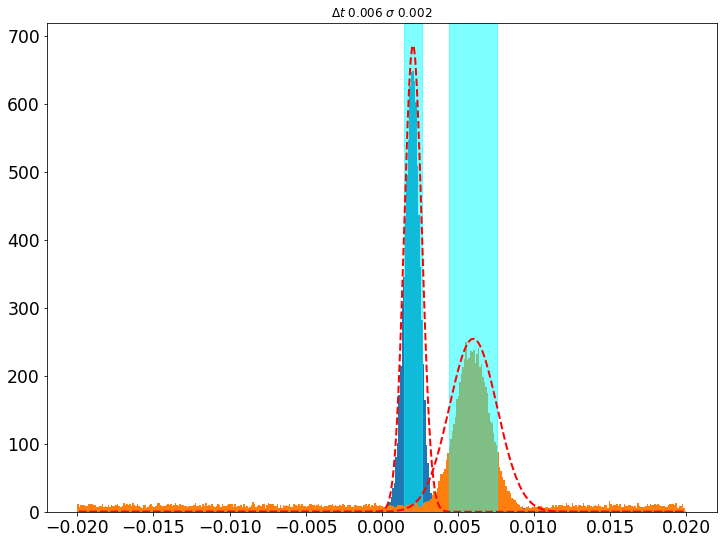

In [6]:
fit_latency(stim_times, A_spikes, plot=True)
fit_latency(stim_times, C_spikes, plot=True)

In [7]:
def make_variables(x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma, z_cutoff):
    Z, X, Y, stim_times = calculate_regressors(x, y, stim_times)
    X = ((X > x_mu - x_sigma) & (X < x_mu + x_sigma)).astype(int)                                                                                                         
    Y = ((Y > y_mu - y_sigma) & (Y < y_mu + y_sigma)).astype(int)
    Z = (abs(Z) < z_cutoff).astype(int)
    return Z, X, Y

In [92]:
iv_params = {
    'x_mu': 2e-3,
    'x_sigma': 1e-3,
    'y_mu': 6e-3,
    'y_sigma': 2e-3,
    'z_cutoff': 1e-3
}

Z, X, Y = make_variables(A_spikes, C_spikes, stim_times, **iv_params)

model = LogisticRegression(C=1e5, solver='liblinear')
fit = model.fit(X.reshape(-1,1), Y)
prob = model.predict_proba([[1], [0]])[:,0]
beta = float(np.diff(prob))
beta

0.6050049130090973

In [93]:
sum((Y - Y.mean()) * (Z - Z.mean())) / sum((X - X.mean()) * (Z - Z.mean()))

0.5268115412792798

In [94]:
Y[X==1].mean(), Y[X==0].mean(), Y[X==1].mean() - Y[X==0].mean()

(0.7302468357091796, 0.12524184186766413, 0.6050049938415154)

In [95]:
any((X==1) & (Z==1)), sum(Z==1)

(False, 152)

In [99]:
Y[(X==1) & (Z==0)].mean() - Y[(X==0) & (Z==1)].mean() - Y[(X==0) & (Z==0)].mean()

0.42197368605435576

In [100]:
Y[(X==1) & (Z==0)].mean(), Y[(X==0) & (Z==1)].mean(), Y[(X==1) & (Z==1)].mean(), Y[(X==0) & (Z==0)].mean()

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.7302468357091796, 0.18421052631578946, nan, 0.12406262333903434)

In [101]:
from torch.distributions import constraints
from pyro.optim import SGD
from pyro.infer import Trace_ELBO, TraceEnum_ELBO
import matplotlib.pyplot as plt
from pyro.contrib.autoguide import AutoDiagonalNormal


def svi(temperature_model, guide, obs, num_steps = 5000, plot = False):
    pyro.clear_param_store()
    svi = pyro.infer.SVI(model=temperature_model,
                         guide=guide,
                         optim=SGD({"lr": 0.001, "momentum":0.1}),
                         loss=Trace_ELBO())

    losses, a,b  = [], [], []
    
    for t in range(num_steps):
        losses.append(svi.step(obs))

    if (plot):
        plt.plot(losses)
        plt.title("ELBO")
        plt.xlabel("step")
        plt.ylabel("loss");
        plt.show()

In [102]:
pyro.clear_param_store()

obs = {
    'counts_0': Z[:500].astype(float),
    'counts_1': X[:500].astype(float),
    'counts_2': Y[:500].astype(float),
}

def model(obs):
    p_0 = pyro.param('p_0', torch.tensor(0.1))
    p_1 = pyro.param('p_1', torch.tensor(0.1))
    p_2 = pyro.param('p_2', torch.tensor(0.1))
    coupling_0 = pyro.param('coupling_0', torch.tensor(0.7))
    coupling_1 = pyro.param('coupling_1', torch.tensor(0.7))
    for i in range(obs['counts_2'].shape[0]):
        spike_0 = pyro.sample(
            'spike_0_{}'.format(i), dist.Bernoulli(p_0), 
            obs=obs['counts_0'][i])
        spike_1 = pyro.sample(
            'spike_1_{}'.format(i), dist.Bernoulli(p_1 + coupling_0 * spike_0), 
            obs=obs['counts_1'][i])
#         spike_1 = pyro.sample(
#             'spike_1_{}'.format(i), dist.Bernoulli(p_1), 
#             obs=obs['counts_1'][i])
        spike_2 = pyro.sample(
            'spike_2_{}'.format(i), dist.Bernoulli(p_2 + coupling_1 * spike_1), 
            obs=obs['counts_2'][i])

def guide(obs):
    pass

#Run inference
svi(model, guide, obs, num_steps=1000)

In [103]:
#Print results
# print('Coupling_0:', pyro.param("coupling_0").item())
print('Coupling_1:', pyro.param("coupling_1").item())
# print('Firing neuron 0:', pyro.param("p_0").item())
print('Firing neuron 1:', pyro.param("p_1").item())
print('Firing neuron 2:', pyro.param("p_2").item())

Coupling_1: 0.8179811835289001
Firing neuron 1: 4.1697564125061035
Firing neuron 2: -1.0368393659591675


# Increasing hit chance A -> C

In [58]:
results = []
for h in tqdm(np.arange(0, 1.1, .1)):
    stim_params = {
        'stop_time': 2000, # seconds
        'stim_rate': 30, # rate of stimulation (gets reduced by pruning for minimum inter stimulus interval)
        'stim_isi_min': 30e-3, # minimum inter stimulus interval
    }
    neuron_params = {
        'refractory': 4e-3, # 4 ms
        'latency': 4e-3, # post response delay
        'latency_std': 1e-3,
        'pre_hit_chance': h, # fraction of spikes that are driven by the presynaptic neuron
        'post_rate': 5, # Hz
        'pre_rate': 5, # base rate
        'stim_hit_chance': .9, # fraction of spikes that are driven by the stimulation
        'stim_latency': 2e-3, # latency from stim to pre response
        'stim_latency_std': .5e-3,
        'stop_time': stim_params['stop_time'],
    }
    iv_params = {
#         'x_mu': 2e-3,
#         'x_sigma': 1e-3,
#         'y_mu': 6e-3,
#         'y_sigma': 2e-3,
    #     'n_bases': 10,
    #     'bin_size': 1e-3,
    #     'offset': 1e-2
    }
    
    stim_times = generate_stim_times(**stim_params) 
    
    A_spikes, C_spikes = generate_neurons(stim_times, make_post=True, **neuron_params)

    B_spikes = generate_neurons(stim_times, make_post=False, **neuron_params)

    beta_AC = IV(
        x=A_spikes, y=C_spikes, stim_times=stim_times, **iv_params)
    
    beta_BC = IV(
        x=B_spikes, y=C_spikes, stim_times=stim_times, **iv_params)
    
    trans_prob_params = {
        'y_mu': 4e-3,
        'y_sigma': 1e-3,
        'bin_size': 1e-3,
        'limit': 15e-3,
        'hollow_fraction': .8,
        'width': 100
    }

    tr_AC = transfer_probability(A_spikes, C_spikes, **trans_prob_params)[0]
    tr_BC = transfer_probability(B_spikes, C_spikes, **trans_prob_params)[0]
    
    res = {
        'A_rate': len(A_spikes) / neuron_params['stop_time'], 
        'B_rate': len(B_spikes) / neuron_params['stop_time'], 
        'C_rate': len(C_spikes) / neuron_params['stop_time'],
        'S_rate': len(stim_times) / neuron_params['stop_time'],
        'C_induced_rate': (len(C_spikes) / neuron_params['stop_time']) - neuron_params['post_rate'],
        'beta_AC': beta_AC,
        'beta_BC': beta_BC,
        'tr_AC': tr_AC,
        'tr_BC': tr_BC
    }
    results.append({**stim_params, **neuron_params, **iv_params, **res})
    
results = pd.DataFrame(results)
results

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

,A_rate,B_rate,C_induced_rate,C_rate,S_rate,beta_AC,beta_BC,latency,latency_std,post_rate,...,pre_rate,refractory,stim_hit_chance,stim_isi_min,stim_latency,stim_latency_std,stim_rate,stop_time,tr_AC,tr_BC
0,18.5990,18.5900,-0.1045,4.8955,15.8310,0.018148,-0.014105,0.004,0.001,5,...,5,0.004,0.9,0.03,0.002,0.0005,30,2000,-0.000723,-0.000548
1,18.5855,18.5565,1.6825,6.6825,15.7920,0.251208,0.033418,0.004,0.001,5,...,5,0.004,0.9,0.03,0.002,0.0005,30,2000,0.038688,0.024135
2,18.6155,18.5575,3.4850,8.4850,15.8040,0.380335,-0.017659,0.004,0.001,5,...,5,0.004,0.9,0.03,0.002,0.0005,30,2000,0.078136,0.049680
3,18.5535,18.5655,5.2460,10.2460,15.7860,0.434271,0.077480,0.004,0.001,5,...,5,0.004,0.9,0.03,0.002,0.0005,30,2000,0.118088,0.073582
4,18.4715,18.4825,6.9905,11.9905,15.7150,0.486080,-0.002191,0.004,0.001,5,...,5,0.004,0.9,0.03,0.002,0.0005,30,2000,0.162998,0.102199
5,18.5520,18.5450,8.8170,13.8170,15.7640,0.566683,0.036363,0.004,0.001,5,...,5,0.004,0.9,0.03,0.002,0.0005,30,2000,0.198575,0.122687
6,18.5470,18.5295,10.5575,15.5575,15.7825,0.598800,0.045814,0.004,0.001,5,...,5,0.004,0.9,0.03,0.002,0.0005,30,2000,0.236651,0.151832
7,18.5840,18.5685,12.3920,17.3920,15.7895,0.601938,0.013297,0.004,0.001,5,...,5,0.004,0.9,0.03,0.002,0.0005,30,2000,0.279479,0.175411
8,18.5865,18.5425,14.1665,19.1665,15.7865,0.639627,-0.000024,0.004,0.001,5,...,5,0.004,0.9,0.03,0.002,0.0005,30,2000,0.321579,0.200838
9,18.5590,18.5515,15.9140,20.9140,15.7760,0.665806,-0.001009,0.004,0.001,5,...,5,0.004,0.9,0.03,0.002,0.0005,30,2000,0.359774,0.221880


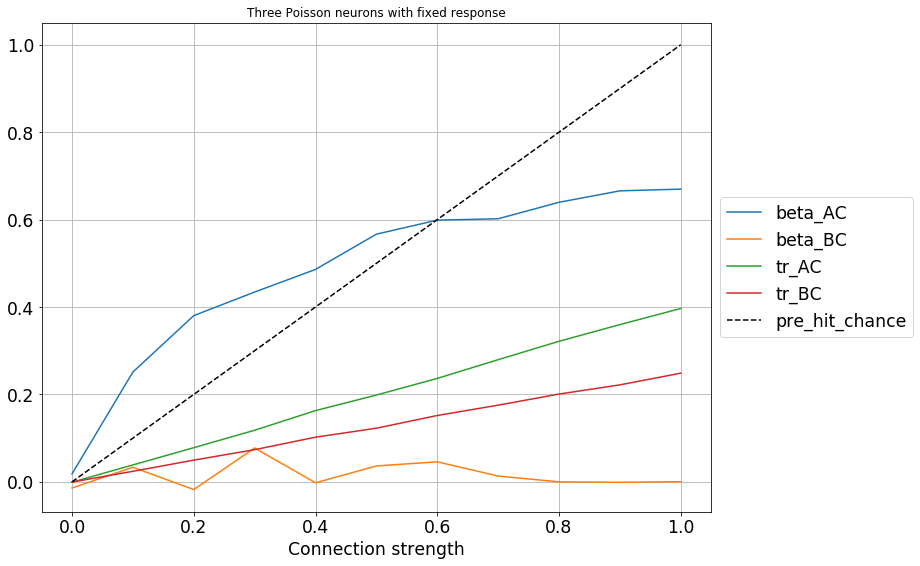

In [59]:
keys = [
#     'A_rate',
#     'B_rate',
#     'C_rate',
#     'S_rate',
    'beta_AC',
    'beta_BC',
    'tr_AC',
    'tr_BC'
    
#     'C_induced_rate'
]

cmap = cm.get_cmap('tab10')
cnt = 0
for key in keys:
    plt.plot(results['pre_hit_chance'], results[key], label=key, color=cmap(cnt))
    cnt += 1
plt.grid(True)

# plt.plot(results['pre_hit_chance'], results.C_induced_rate / (results.A_rate + results.S_rate), '--k')
plt.plot(results['pre_hit_chance'], results['pre_hit_chance'], '--k')

plt.title('Three Poisson neurons with fixed response')
plt.xlabel('Connection strength')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

(0.5982099561113456,
 0.023784050155139277,
 0.23612691317680629,
 0.14754605244165137)

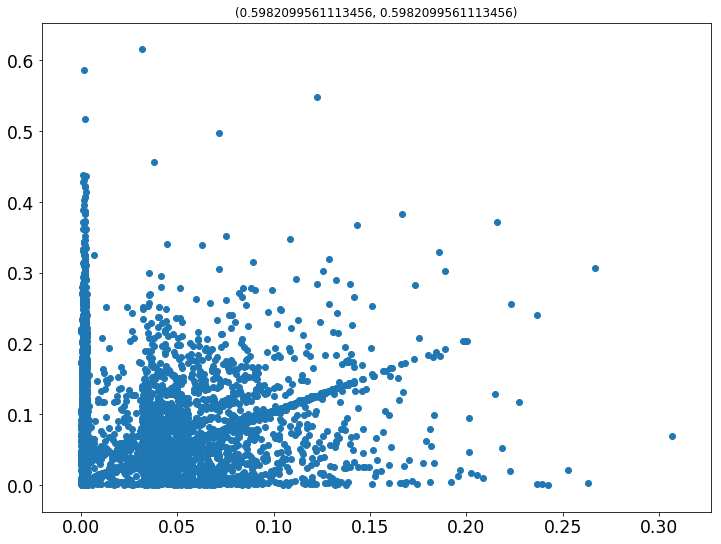

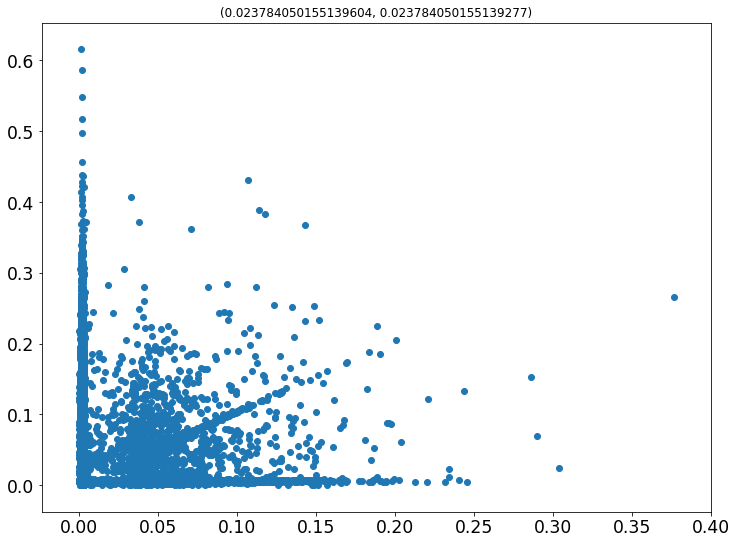

In [62]:
stim_params = {
    'stop_time': 2000, # seconds
    'stim_rate': 30, # rate of stimulation (gets reduced by pruning for minimum inter stimulus interval)
    'stim_isi_min': 30e-3, # minimum inter stimulus interval
}
neuron_params = {
    'refractory': 4e-3, # 4 ms
    'latency': 4e-3, # post response delay
    'latency_std': 1e-3,
    'pre_hit_chance': .6, # fraction of spikes that are driven by the presynaptic neuron
    'post_rate': 5, # Hz
    'pre_rate': 5, # base rate
    'stim_hit_chance': .9, # fraction of spikes that are driven by the stimulation
    'stim_latency': 2e-3, # latency from stim to pre response
    'stim_latency_std': .5e-3,
    'stop_time': stim_params['stop_time'],
}
iv_params = {
#         'x_mu': 2e-3,
#         'x_sigma': 1e-3,
#         'y_mu': 6e-3,
#         'y_sigma': 2e-3,
#     'n_bases': 10,
#     'bin_size': 1e-3,
#     'offset': 1e-2
}

stim_times = generate_stim_times(**stim_params) 

A_spikes, C_spikes = generate_neurons(stim_times, make_post=True, **neuron_params)

B_spikes = generate_neurons(stim_times, make_post=False, **neuron_params)

beta_AC = single_stim_connection_probability(A_spikes, C_spikes, stim_times, plot=True)
beta_BC = single_stim_connection_probability(B_spikes, C_spikes, stim_times, plot=True)

trans_prob_params = {
    'y_mu': 4e-3,
    'y_sigma': 1e-3,
    'bin_size': 1e-3,
    'limit': 15e-3,
    'hollow_fraction': .6,
    'width': 60
}

tr_AC = transfer_probability(A_spikes, C_spikes, **trans_prob_params)[0]
tr_BC = transfer_probability(B_spikes, C_spikes, **trans_prob_params)[0]


beta_AC, beta_BC, tr_AC, tr_BC

# Increasing stop time

In [27]:
results = []
for h in tqdm(np.arange(100, 6100, 10)):
    stim_params = {
        'stop_time': h, # seconds
        'stim_rate': 30, # rate of stimulation (gets reduced by pruning for minimum inter stimulus interval)
        'stim_isi_min': 50e-3, # minimum inter stimulus interval
    }
    neuron_params = {
        'refractory': 4e-3, # 4 ms
        'latency': 6e-3, # post response delay
        'pre_hit_chance': .5, # fraction of spikes that are driven by the presynaptic neuron
        'post_rate': 5, # Hz
        'pre_rate': 5, # base rate
        'stim_hit_chance': .8, # fraction of spikes that are driven by the stimulation
        'stim_latency': 5e-4, # latency from stim to pre response
        'stop_time': stim_params['stop_time'],
    }
    iv_params = {
        'winsize': 8e-3
    }
    
    stim_times = generate_stim_times(**stim_params) 
    
    A_spikes, C_spikes = generate_neurons(stim_times, make_post=True, **neuron_params)

    B_spikes = generate_neurons(stim_times, make_post=False, **neuron_params)

    beta_AC = IV(
        x=A_spikes, y=C_spikes, stim_times=stim_times, **iv_params)
    
    beta_BC = IV(
        x=B_spikes, y=C_spikes, stim_times=stim_times, **iv_params)
    
    res = {
        'A_rate': len(A_spikes) / neuron_params['stop_time'], 
        'B_rate': len(B_spikes) / neuron_params['stop_time'], 
        'C_rate': len(C_spikes) / neuron_params['stop_time'],
        'S_rate': len(stim_times) / neuron_params['stop_time'],
        'C_induced_rate': (len(C_spikes) / neuron_params['stop_time']) - neuron_params['post_rate'],
        'beta_AC': beta_AC,
        'beta_BC': beta_BC
    }
    results.append({**stim_params, **neuron_params, **iv_params, **res})
    
results = pd.DataFrame(results)
results.head()

HBox(children=(IntProgress(value=0, max=600), HTML(value='')))

,A_rate,B_rate,C_induced_rate,C_rate,S_rate,beta_AC,beta_BC,latency,post_rate,pre_hit_chance,pre_rate,refractory,stim_hit_chance,stim_isi_min,stim_latency,stim_rate,stop_time,winsize
0,14.140000,14.090000,6.690000,11.690000,12.100000,9.374244,10.913132,0.006,5,0.5,5,0.004,0.8,0.05,0.0005,30,100,0.008
1,14.181818,14.354545,6.627273,11.627273,12.190909,6.865382,1.072448,0.006,5,0.5,5,0.004,0.8,0.05,0.0005,30,110,0.008
2,14.091667,14.183333,6.658333,11.658333,12.083333,1.830445,-4.895754,0.006,5,0.5,5,0.004,0.8,0.05,0.0005,30,120,0.008
3,14.215385,14.200000,6.876923,11.876923,11.992308,17.225966,16.000537,0.006,5,0.5,5,0.004,0.8,0.05,0.0005,30,130,0.008
4,14.042857,14.121429,6.564286,11.564286,11.964286,20.628337,18.072406,0.006,5,0.5,5,0.004,0.8,0.05,0.0005,30,140,0.008
5,14.093333,14.193333,6.653333,11.653333,12.020000,-6.187352,2.564717,0.006,5,0.5,5,0.004,0.8,0.05,0.0005,30,150,0.008
6,14.112500,14.187500,6.718750,11.718750,12.031250,2.361970,-11.751113,0.006,5,0.5,5,0.004,0.8,0.05,0.0005,30,160,0.008
7,14.170588,14.200000,6.700000,11.700000,12.076471,9.828869,-2.801731,0.006,5,0.5,5,0.004,0.8,0.05,0.0005,30,170,0.008
8,14.205556,14.122222,6.777778,11.777778,11.983333,27.150225,-0.006820,0.006,5,0.5,5,0.004,0.8,0.05,0.0005,30,180,0.008
9,14.184211,14.105263,6.742105,11.742105,12.005263,-0.283364,4.630576,0.006,5,0.5,5,0.004,0.8,0.05,0.0005,30,190,0.008


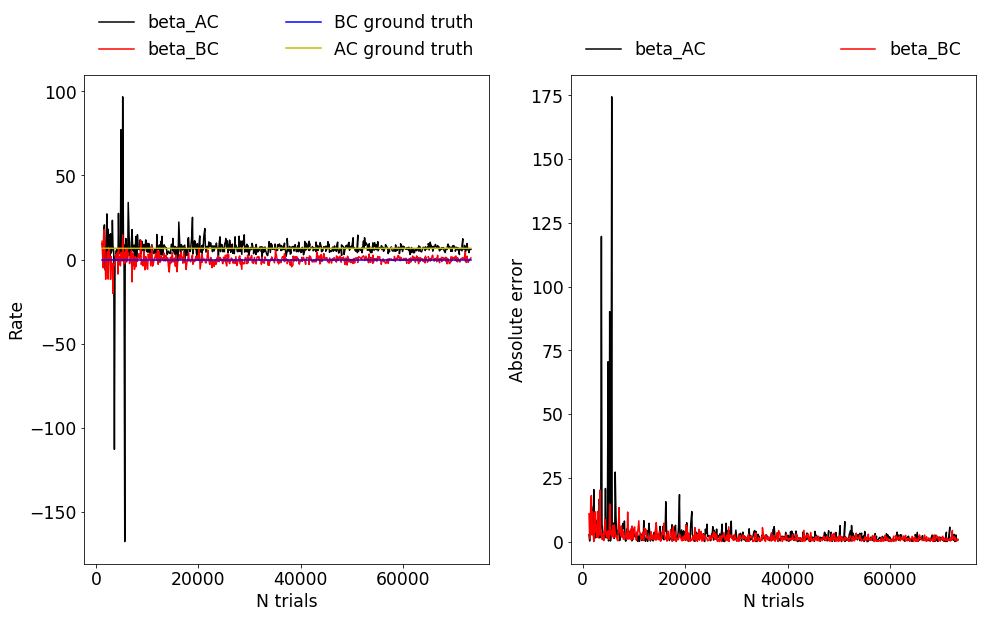

In [45]:
fig, (ax_v, ax_e) = plt.subplots(1, 2, figsize=(16, 9))

ax_v.plot(
    results['stop_time'] * results['S_rate'], 
    results['beta_AC'], 
    color='k')

ax_v.plot(
    results['stop_time'] * results['S_rate'], 
    results['beta_BC'], 
    color='r')

ax_v.plot(
    results['stop_time'] * results['S_rate'], 
    np.zeros(len(results['stop_time'])), 
    label='BC ground truth', color='b')

ax_v.plot(
    results['stop_time'] * results['S_rate'], 
    results['C_induced_rate'], 
    label='AC ground truth', color='y')

ax_e.plot(
    results['stop_time'] * results['S_rate'], 
    abs(results['beta_AC'] - results['C_induced_rate']), 
    label='beta_AC', color='k')

ax_e.plot(
    results['stop_time'] * results['S_rate'], 
    abs(results['beta_BC'] - 0), 
    label='beta_BC', color='r')

ax_v.set_xlabel('N trials')
ax_e.set_xlabel('N trials')
ax_e.set_ylabel('Absolute error')
ax_v.set_ylabel('Rate')

ax_v.legend(
    bbox_to_anchor=(0., 1.00, 1., .102), loc=3,
    ncol=2, mode="expand", frameon=False)

ax_e.legend(
    bbox_to_anchor=(0., 1.00, 1., .102), loc=3,
    ncol=2, mode="expand", frameon=False)